# Application Example: Gyroscope Allan Variance

The signals of, e.g., angular rate sensors contain white noise along with colored noise resulting from a variety of sources. With the ``pyplnoise``module, this noise can be generated and added on top of the deterministic sensor errors in a sensor model. Such a sensor model can be used for example for the simulation of a Kalman filter accommodating correlated noise terms.

In the code below it is outlined how you can use ``pyplnoise`` to approximate the Allan variance of a real yaw rate sensor. Familiarity with the IEEE Standard 952 is helpful.

In [1]:
%matplotlib inline
import pyplnoise
import allan
import numpy as np
import matplotlib.pyplot as plt

The angular rate sensor is described by the quantities $N$ (angle random walk), $B$ (bias instability) and $K$ (rate random walk) from the IEEE Std 952. The values prescribed here approximate the properties of a Bosch SMI130 yaw rate sensor.

In [2]:
N = 5e-3 # °/sqrt(s) = 0.3 °/sqrt(h)
B = 7e-4 # °/s = 2.5 °/h
K = 6e-6 # °/s/sqrt(s)

Define the sampling rate ``fs`` and initialize noise sources:

In [3]:
fs = 10.
npts = 70000000
t = np.linspace(0., npts/fs, num=npts)

In [4]:
whnoise = pyplnoise.WhiteNoise(fs)
rdnoise = pyplnoise.RedNoise(fs, 1e-8)
pknoise = pyplnoise.PinkNoise(fs, 1e-6, fs/2.)

Now create an artifical sensor noise signal $w_{noise}$ from the individual noise sources denoted by $\xi$. The noise is additive and the coefficients $N$, $B$ and $K$ from the IEEE Std 952 enter as follows:

$$w_{noise} = N\xi_{white} + \frac{B}{\sqrt{2\pi}}\xi_{pink} + \frac{K}{2\pi}\xi_{red}$$

In [5]:
w = N * whnoise.get_series(npts) + B / np.sqrt(2. * np.pi) * pknoise.get_series(npts) +\
K / (2. * np.pi) * rdnoise.get_series(npts)

Now calculate the Allan variance. The module ``allan`` is not provided by ``pyplnoise``, but many similar codes can be found on pypi.

In [6]:
tau, avar, adev, error_adev_pct = allan.allan_variance(w, dt=1./fs, n_clusters=8000,
                                                       verbose=False)

In [7]:
# omit values with insufficient statistical quality
idx_valid = error_adev_pct < 10
avar_valid = avar[idx_valid]
adev_valid = adev[idx_valid]
tau_valid = tau[idx_valid]

Here's how the calculated Allan deviation looks like.

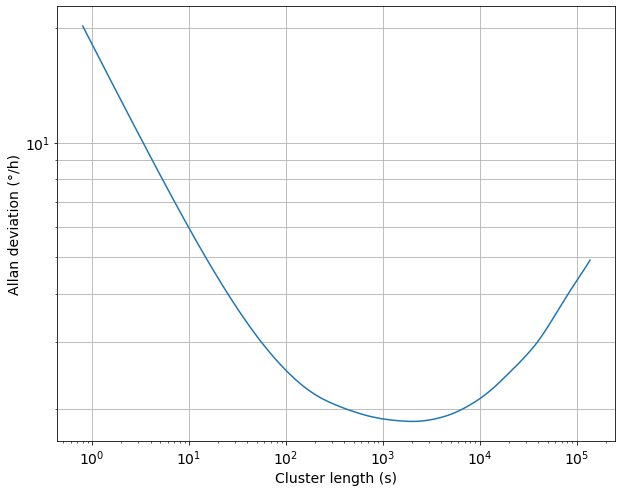

In [15]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10,8))
ax = fig.gca()
ax.loglog(tau_valid, adev_valid*3600)
ax.set_xlabel("Cluster length (s)")
ax.set_ylabel("Allan deviation (°/h)")
ax.grid(True, which='major')
ax.grid(True, which='minor', axis='y')

Let's extract the properties $N$, $B$ and $K$ automatically:

In [9]:
noise_density, a_n_fit, b_n_fit = allan.read_noise_density(adev_valid, tau_valid)
print("Extracted angle random walk: N = {:.4g} °/s/sqrt(Hz) = {:.5f} °/sqrt(h)"
      .format(noise_density, noise_density*60))
bias_instability = allan.read_bias_instability(adev_valid, tau_valid)
print("Extracted bias instability: B = {:.4g} °/s = {:.5f} °/h"
      .format(bias_instability, bias_instability*3600))
rate_random_walk, a_k_fit, b_k_fit = allan.read_rate_random_walk(adev_valid, tau_valid)
print("Extracted rate random walk: K = {:.4g} °/s^(3/2) = {:.5f} °/h^(3/2)"
      .format(rate_random_walk, rate_random_walk*3600**(3/2)))

Extracted angle random walk: N = 0.005027 °/s/sqrt(Hz) = 0.30159 °/sqrt(h)
Extracted bias instability: B = 0.0007754 °/s = 2.79154 °/h
Extracted rate random walk: K = 6.792e-06 °/s^(3/2) = 1.46705 °/h^(3/2)


If you rather prefer to find these values manually, you can read off the value of the red line at $\tau = 1$ to get $N$. The value of the green line at $\tau = 3$ is equal to $K$, and multiplication of the global minimum by 0.664 yields $B$.

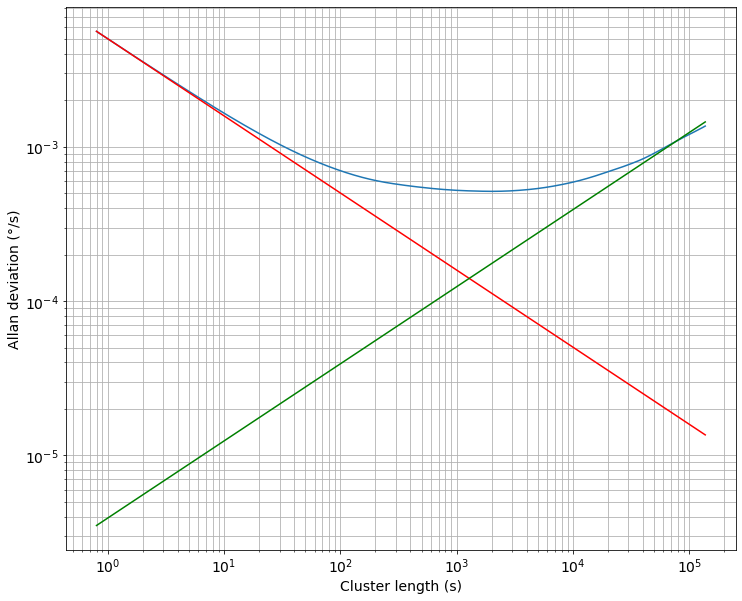

In [16]:
fit_vals_n = np.power(10.0, a_n_fit * np.log10(tau_valid) + b_n_fit)
fit_vals_k = np.power(10.0, a_k_fit * np.log10(tau_valid) + b_k_fit)
fig = plt.figure(figsize=(12,10))
ax = fig.gca()
ax.loglog(tau_valid, adev_valid)
ax.loglog(tau_valid, fit_vals_n, color='red')
ax.loglog(tau_valid, fit_vals_k, color='green')
ax.set_xlabel("Cluster length (s)")
ax.set_ylabel("Allan deviation (°/s)")
ax.grid(True, which='both')